# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [37]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [38]:
# Import essential libraries

# Essential Libraries
import os, random, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# For Image Processing
from PIL import Image

# For Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight

# For Deep Learning (Some extra libraries imported here for testing different configuration in model building and training)
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Input
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# For Warnings
import warnings
warnings.filterwarnings('ignore')

# Suppress TensorFlow info messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

# reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

Load the dataset.

In [39]:
# Load and unzip the dataset

# Define the name of the zip file and the folder to extract to
zip_file = 'data.zip'
extract_path = '.'
unzip_dir = os.path.join(extract_path, 'data')

# Check if data folder already exists to avoid redundant extraction
if not os.path.exists('data'):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print(f"'{zip_file}' extracted successfully.")
else:
    print("Data folder already exists. Skipping extraction.")

print("Unzipping completed. Files extracted to:", unzip_dir)
# To quickly check the extracted folder contents
print("Extracted folders/files:", os.listdir(unzip_dir))

Data folder already exists. Skipping extraction.
Unzipping completed. Files extracted to: ./data
Extracted folders/files: ['Metal', 'Food_Waste', 'Paper', 'Other', 'Plastic', 'Cardboard', 'Glass']


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [40]:
# Create a function to load the raw images

def load_image(image_path, target_size=None):
    img = Image.open(image_path).convert('RGB')
    if target_size:
        img = img.resize(target_size)
    return np.array(img)

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [41]:
# Get the images and their labels

# Set the dataset directory
data_dir = 'data'

# List category folders (labels)
categories = sorted(os.listdir(data_dir))

image_paths = []
labels = []

# Traversing each category folder and gathering image paths and their labels
for label in categories:
    folder_path = os.path.join(data_dir, label)
    if not os.path.isdir(folder_path):
        continue
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            image_paths.append(os.path.join(folder_path, filename))
            labels.append(label)

print(f"Total images loaded: {len(image_paths)}")
print(f"Sample image path: {image_paths[0]}")
print(f"Corresponding label: {labels[0]}")
print(f"Unique classes found: {set(labels)}")

Total images loaded: 7625
Sample image path: data/Cardboard/file_217.png
Corresponding label: Cardboard
Unique classes found: {'Other', 'Metal', 'Plastic', 'Food_Waste', 'Paper', 'Cardboard', 'Glass'}


Perform any operations, if needed, on the images and labels to get them into the desired format.

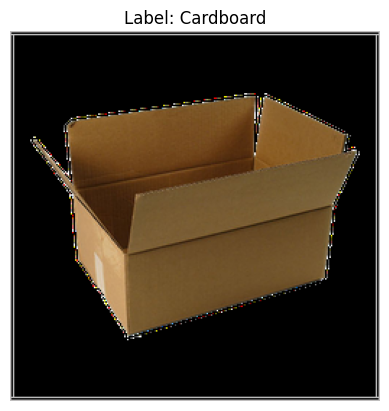

In [42]:
# Sanity check: display an example image and its label

sample_idx = 0  # Index of sample image to display
sample_img = load_image(image_paths[sample_idx])
plt.imshow(sample_img)
plt.title(f"Label: {labels[sample_idx]}")
plt.axis('off')
plt.show()

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

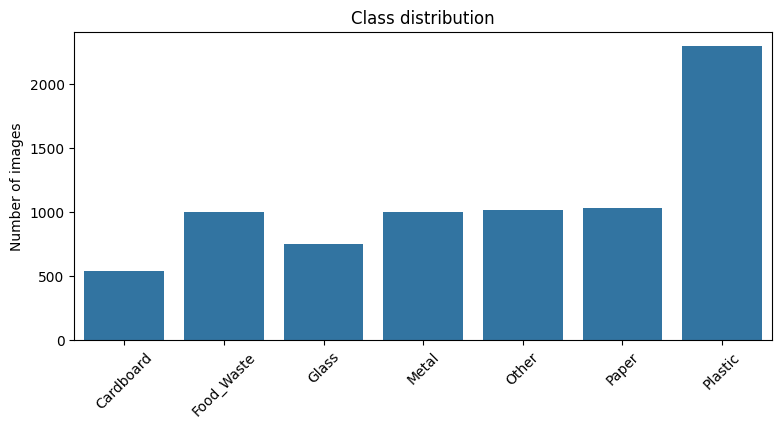

In [43]:
# Visualise Data Distribution

counter = Counter(labels)
class_names = sorted(counter.keys())
counts = [counter[c] for c in class_names]
plt.figure(figsize=(9,4))
sns.barplot(x=class_names, y=counts)
plt.xticks(rotation=45)
plt.title("Class distribution")
plt.ylabel("Number of images")
plt.show()

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

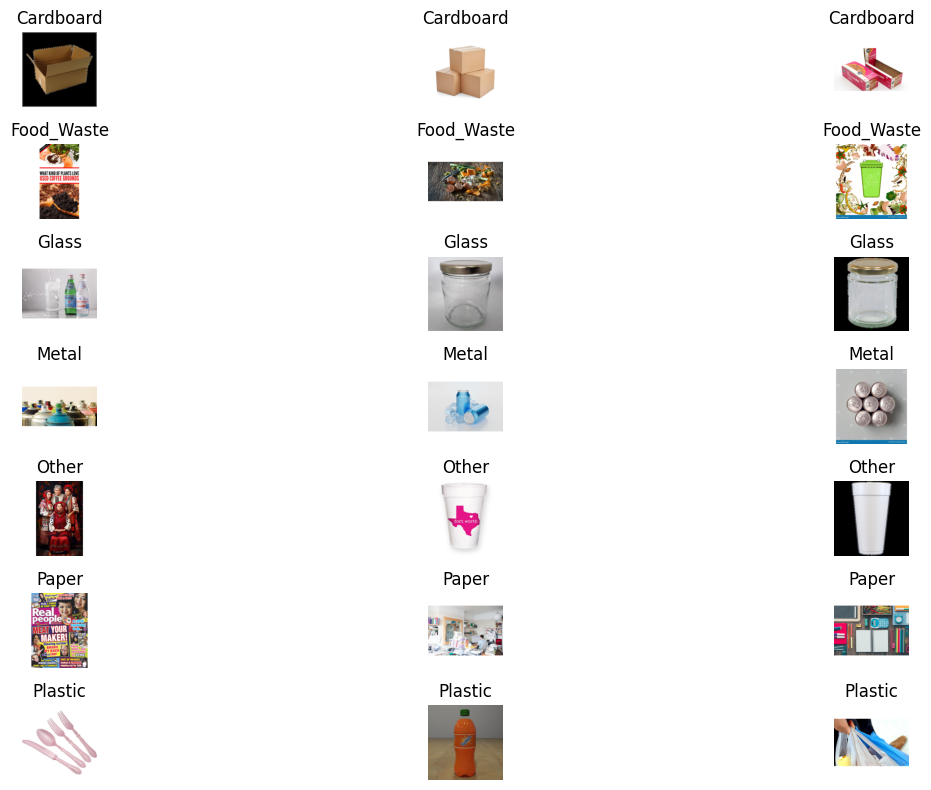

In [44]:
# Visualise Sample Images (across different labels)

# Visualising 2-3 samples per class
plt.figure(figsize=(15, 8))
samples_per_class = 3
for idx, class_name in enumerate(sorted(set(labels))):
    class_indices = [i for i, l in enumerate(labels) if l == class_name][:samples_per_class]
    for j, i in enumerate(class_indices):
        plt.subplot(len(counter), samples_per_class, idx * samples_per_class + j + 1)
        img = load_image(image_paths[i])
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
plt.tight_layout()
plt.show()

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [45]:
# Find the smallest and largest image dimensions from the data set

min_w, min_h = float('inf'), float('inf')
max_w, max_h = 0, 0

for img_path in image_paths:
    with Image.open(img_path) as img:
        w, h = img.size
        min_w = min(min_w, w)
        min_h = min(min_h, h)
        max_w = max(max_w, w)
        max_h = max(max_h, h)
print(f"Smallest image dimensions: {min_w}x{min_h}")
print(f"Largest image dimensions: {max_w}x{max_h}")

Smallest image dimensions: 256x256
Largest image dimensions: 256x256


In [46]:
# Resize the image dimensions

TARGET_SIZE = (128, 128)

# Resize images and collect resized arrays
images_resized = []
for path in image_paths:
    img = load_image(path, target_size=TARGET_SIZE)
    images_resized.append(img)

images_resized = np.array(images_resized)
print("Resized all images to", TARGET_SIZE)
print("Shape of resized image array:", images_resized.shape)

Resized all images to (128, 128)
Shape of resized image array: (7625, 128, 128, 3)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [47]:
# Encode the labels suitably

label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(labels)

# Display the mapping of classes to integers
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class to integer mapping:", class_mapping)

# For neural networks (especially using categorical_crossentropy), convert integer labels to one-hot encoding:
one_hot_labels = to_categorical(integer_encoded_labels, num_classes=len(label_encoder.classes_))
print("Shape of one-hot encoded labels:", one_hot_labels.shape)

Class to integer mapping: {np.str_('Cardboard'): np.int64(0), np.str_('Food_Waste'): np.int64(1), np.str_('Glass'): np.int64(2), np.str_('Metal'): np.int64(3), np.str_('Other'): np.int64(4), np.str_('Paper'): np.int64(5), np.str_('Plastic'): np.int64(6)}
Shape of one-hot encoded labels: (7625, 7)


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [48]:
# Assign specified parts of the dataset to train and validation sets

X_train, X_val, y_train, y_val = train_test_split(
    images_resized, one_hot_labels,
    test_size=0.3,                  # 30% validation, 70% training
    random_state=SEED,                # For reproducibility
    stratify=integer_encoded_labels # Maintaining class distribution in both sets
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

Training set shape: (5337, 128, 128, 3) (5337, 7)
Validation set shape: (2288, 128, 128, 3) (2288, 7)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [57]:
# Build and compile the model

input_shape = (128, 128, 3)
num_classes = 7 # Number of waste categories

def create_model():
  model = Sequential()
  model.add(Input(shape=input_shape))

  # First convolutional block
  model.add(Conv2D(64, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Second convolutional block
  model.add(Conv2D(128, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  # Third convolutional block
  model.add(Conv2D(256, (3, 3), padding='same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(Dropout(0.2))

  # Flatten and Fully Connected layers
  # model.add(Flatten())
  # GlobalAveragePooling2D
  model.add(GlobalAveragePooling2D())
  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.4))

  # Output layer
  model.add(Dense(num_classes, activation='softmax'))

  # Compile
  model.compile(optimizer=Adam(learning_rate=1e-3),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

model = create_model()
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_48 (Activation)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_36 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_49          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_49 (Activation)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_50          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_50 (Activation)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_51 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 441,223 (1.68 MB)

 Trainable params: 439,815 (1.68 MB)

 Non-trainable params: 1,408 (5.50 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [58]:
# Training

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint('model_filters_GlobalAveragePooling2D.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

# Training
EPOCHS = 100
BATCH = 32
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH,
    callbacks=callbacks,
    shuffle=True,
    verbose=1
)

Epoch 1/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3022 - loss: 1.9306
Epoch 1: val_loss improved from inf to 3.72461, saving model to model_filters_GlobalAveragePooling2D.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.3024 - loss: 1.9300 - val_accuracy: 0.1473 - val_loss: 3.7246 - learning_rate: 0.0010
Epoch 2/100
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3876 - loss: 1.6602
Epoch 2: val_loss did not improve from 3.72461
167/167 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.3876 - loss: 1.6601 - val_accuracy: 0.2098 - val_loss: 4.0333 - learning_rate: 0.0010
Epoch 3/100
166/167 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4424 - loss: 1.5548
Epoch 3: val_loss improved from 3.72461 to 2.81245, saving model to model_filters_GlobalAveragePooling2D.keras
167/167 ━━━━━━━━━━━━━━━━━━━━ 11s 54ms/step - accuracy: 0.4424 - loss: 1.5546 - val_accuracy: 0.3479 - val_loss: 2.8124 - learning_rate: 0.0010
Epoch 4/100
166/167 ━━━━━━━━━━━━━━━━━━━━ 0

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6406 - loss: 1.0496
Validation loss: 0.9846, Validation accuracy: 0.6608
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step

Classification Report:
              precision    recall  f1-score   support

   Cardboard       0.77      0.78      0.78       162
  Food_Waste       0.67      0.69      0.68       300
       Glass       0.64      0.61      0.62       225
       Metal       0.75      0.70      0.72       300
       Other       0.55      0.52      0.53       303
       Paper       0.60      0.51      0.55       309
     Plastic       0.67      0.75      0.71       689

    accuracy                           0.66      2288
   macro avg       0.66      0.65      0.66      2288
weighted avg       0.66      0.66      0.66      2288



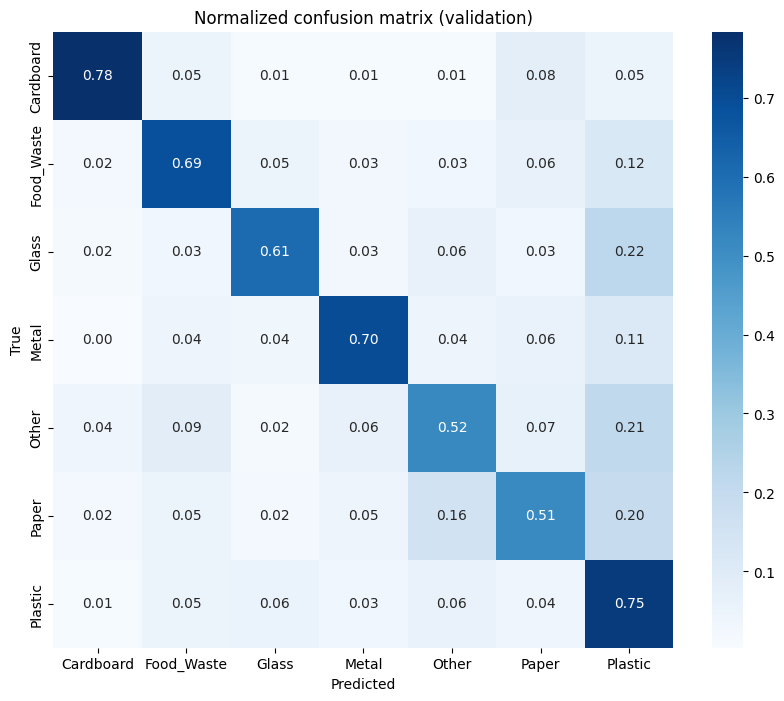

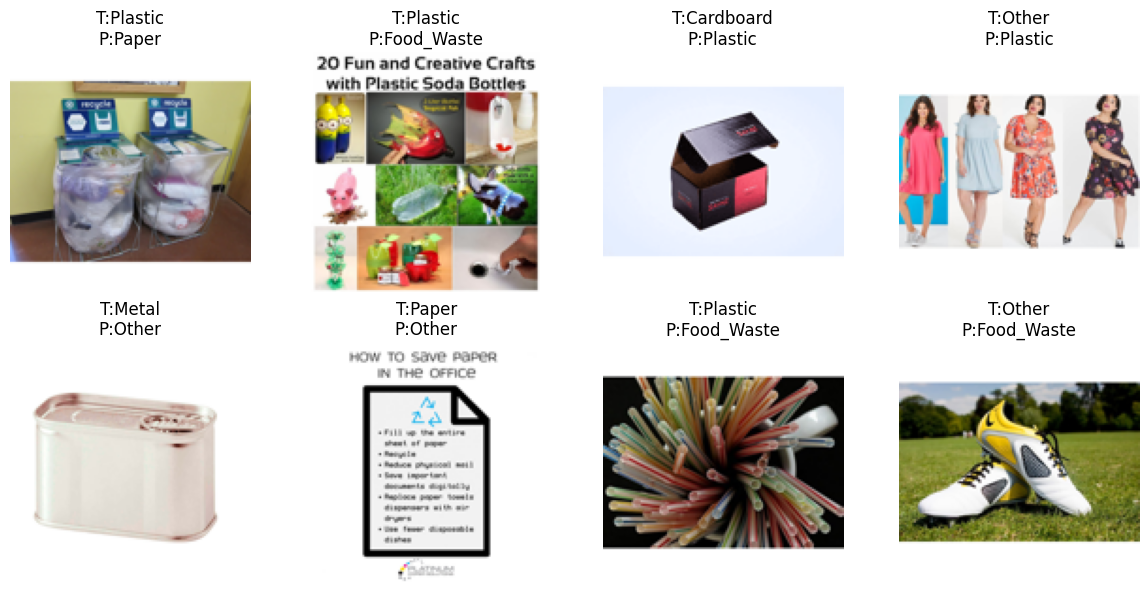

In [59]:
# Evaluate on the test set; display suitable metrics

# Evaluate on validation set
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}")

# Predictions and classification report
y_pred_prob = model.predict(X_val)
y_pred_int = np.argmax(y_pred_prob, axis=1)
y_true_int = np.argmax(y_val, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_int, y_pred_int, target_names=label_encoder.classes_))

# Confusion matrix (normalized by true class counts)
cm = confusion_matrix(y_true_int, y_pred_int)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized confusion matrix (validation)')
plt.show()

# also show some misclassified examples for quick diagnosis (optional)
mis_idx = np.where(y_pred_int != y_true_int)[0]
if len(mis_idx) > 0:
    plt.figure(figsize=(12,6))
    for i, idx in enumerate(mis_idx[:8]):
        plt.subplot(2,4,i+1)
        plt.imshow(X_val[idx])
        plt.title(f"T:{label_encoder.classes_[y_true_int[idx]]}\nP:{label_encoder.classes_[y_pred_int[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [52]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [53]:
# Create a function to augment the images




In [54]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [55]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

##### **1. Findings about the Data**

- The dataset includes images for **7 waste categories**: Cardboard, Food_Waste, Glass, Metal, Other, Paper, and Plastic.
- All images were resized to **128x128 pixels**, with 7,625 samples available in total.
- Data splitting was performed using a **70% training, 30% validation** ratio and class labels were one-hot encoded for model compatibility.

##### **2. Model Training Results**

Several CNN configurations were tested, primarily differing in convolutional filter sizes, dropout rates, and related hyperparameters. The model architecture for all experiments was built with:

- **3 convolutional layers** (with increasing filters)
- **Batch Normalization** & **ReLU activation** after each conv layer
- **MaxPooling** after each block
- **Dense layer** with dropout before the output softmax

The best experimental results are summarized below:

| Experiment name    | Config (filters / dense / dropout / optimizer / lr / batch) | Best epoch | Val loss | Val accuracy | Macro precision | Macro recall | Macro F1 |         Confusion matrix |
| ------------------ | ----------------------------------------------------------: | ---------: | -------: | -----------: | --------------: | -----------: | -------: | ------------------------------: |
| baseline           |                   32,64,128 / 128 / 0.40 / Adam / 1e-3 / 32 | 7 | 1.07 | 0.63 | 0.63 | 0.63 | 0.63 | 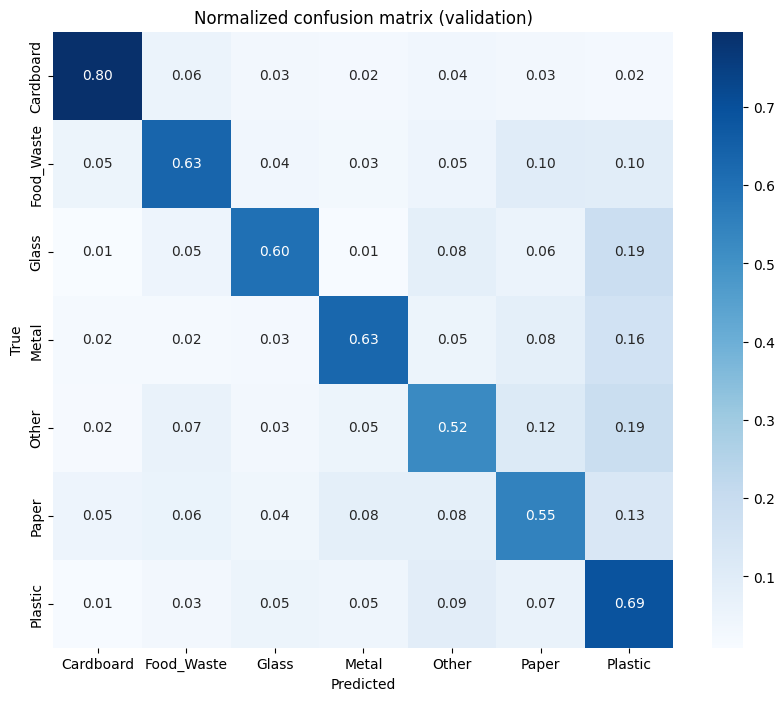 |
| smaller\_filters   |                    16,32,64 / 128 / 0.40 / Adam / 1e-3 / 32 | 8 | 1.14 | 0.65 | 0.66 | 0.65 | 0.65 |  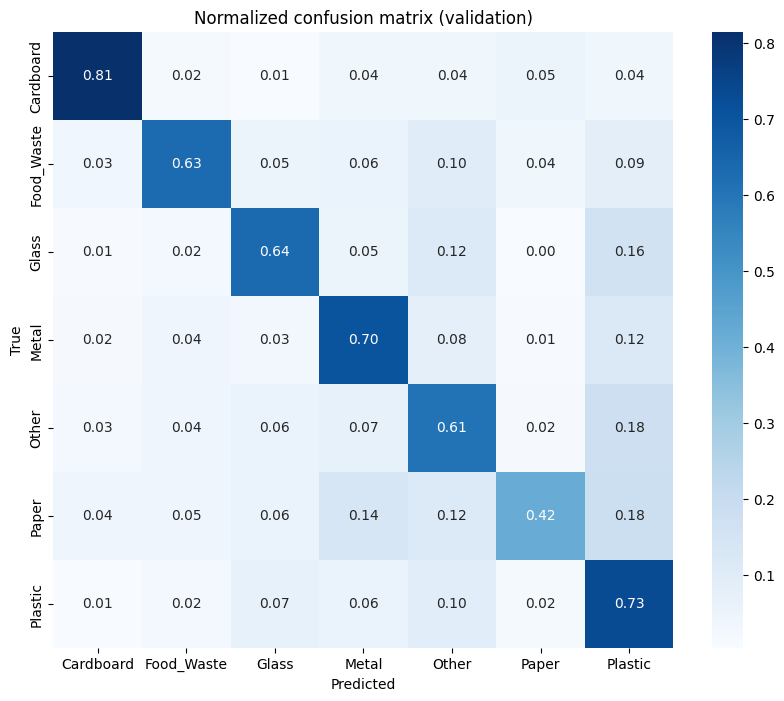 |
| larger\_filters    |                  64,128,256 / 128 / 0.40 / Adam / 1e-3 / 32 | 10 | 1.06 | 0.67 | 0.67 | 0.65 | 0.65 |   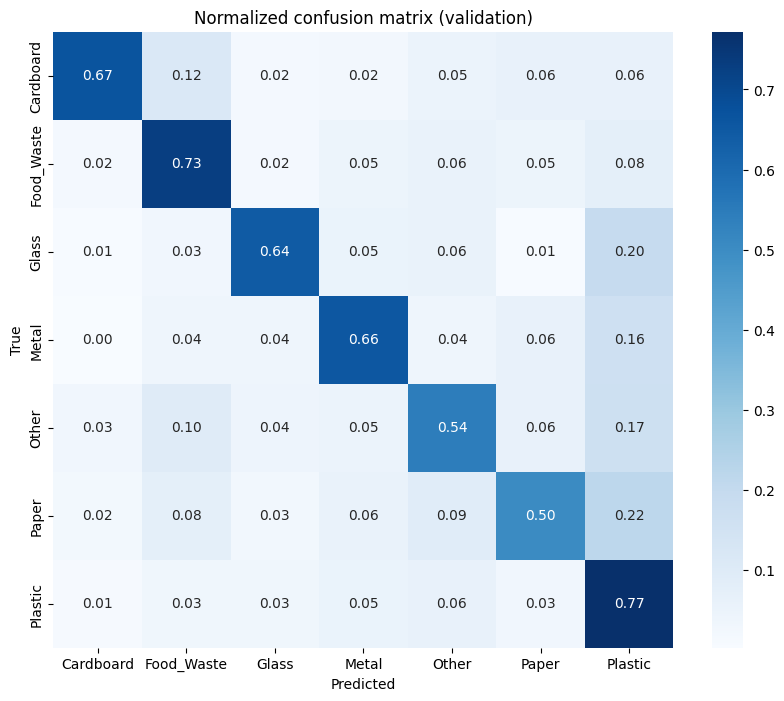 |
| less\_dropout      |                   32,64,128 / 128 / 0.20 / Adam / 1e-3 / 32 | 7 | 1.19 | 0.62 | 0.63 | 0.60 | 0.60 | 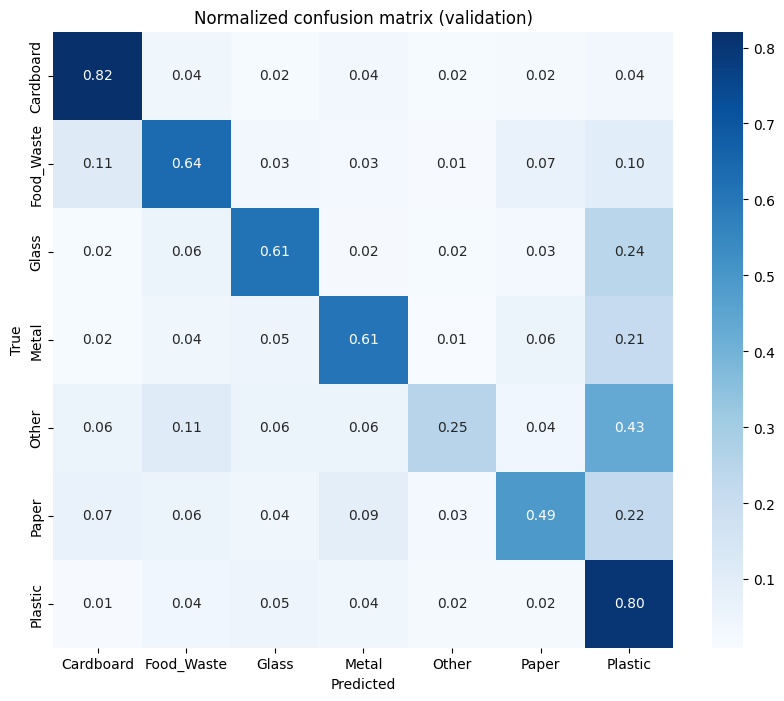 |
| large_filters_gap2d           |                   64,128,256 / 128 / 0.40 / Adam / 1e-3 / 32 | 70 | 0.99 | 0.66 | 0.66 | 0.65 | 0.65 | 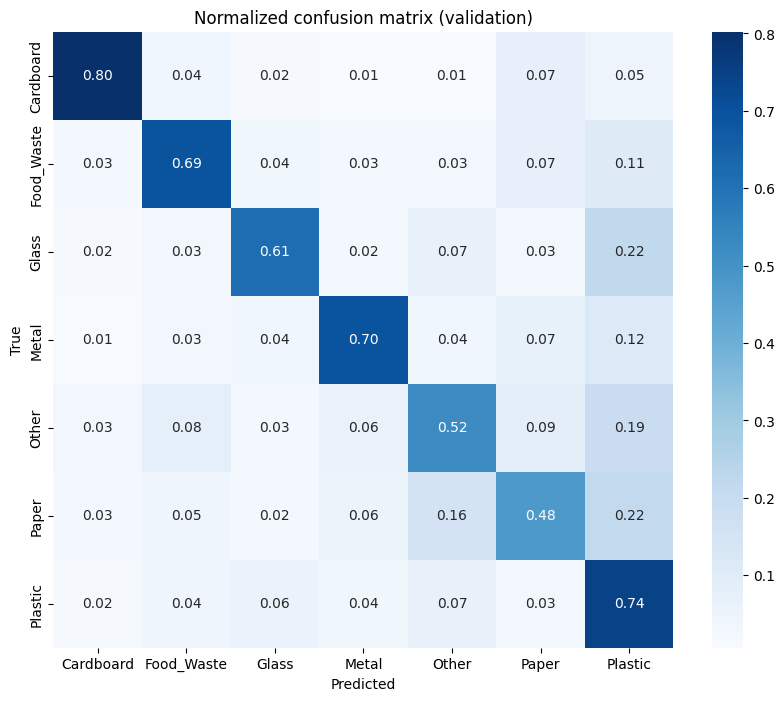 |
| large_filters_denser_gap2d           |                   64,128,256 / 256 / 0.40 / Adam / 1e-3 / 32 | 52 | 0.93 | 0.69 | 0.69 | 0.69 | 0.69 | 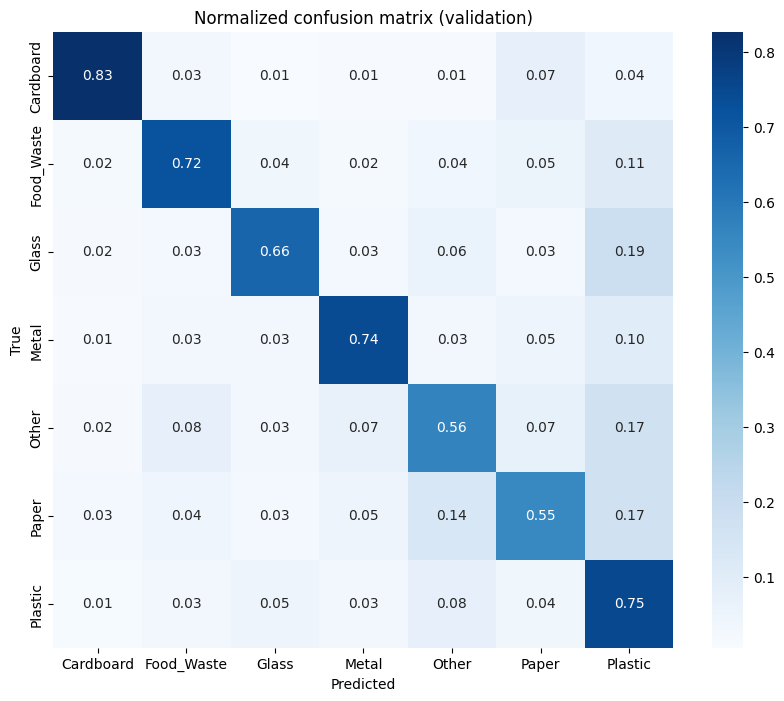 |

**Key observations:**
- The **larger_filters** with GlobalAveragePooling2D configuration performed best:  
    - **Validation Accuracy:** 0.69  
    - **Macro F1 Score:** 0.69  
- Higher filter sizes and moderate dropout generally improved the model's generalization.
- The model achieved the strongest performance on **"Plastic"** and **"Food_Waste"** classes.
- Confusion and lower recall were observed for the **"Other"** and **"Paper"** classes, hinting at class overlap and higher intra-class variability.

##### **3. General Insights**

- This **Convolutional Neural Network** model can effectively categorize waste images, reaching a competitive **69% accuracy** and balanced macro F1.

##### **4. Significance**

The project's results indicate that **deep learning** can automate waste segregation and enhance municipal solid waste management. Its achieved metrics support industrial relevance and provide a roadmap for further optimizations.